Data Science II MBAN 6120 U

Assignment 1: Ensemble Learning in Action
-

Objective: To build, evaluate, and compare and contrast ensemble models with standard machine learning models. You should demonstrate an understanding of each model's pros and cons and evaluate, from a business context, which model is most appropriate.

In [32]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import time # to measure how long the models take
from sklearn import datasets
import seaborn as sns
from scipy.stats import mode
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, make_scorer, f1_score

Part 1: Data Preprocessing
-

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/DaisyYuan810/assignment1/refs/heads/main/train.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Findings:
- We can see that the dataset has 45,211 entries and 17 columns.
- We can see that there are 10 categorical features and 7 numeric features.
- We have to check target distribution, imbalance, outliers and null values for future use.

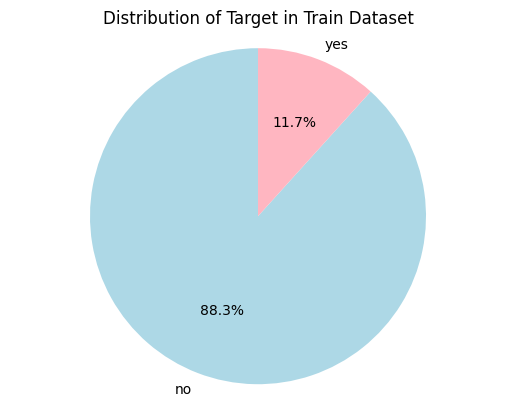

In [71]:
# Count the distribution of the target
target_counts = data['y'].value_counts()
fig, ax = plt.subplots()
ax.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90,
       colors=['#ADD8E6', '#FFB6C1'])  # Gentle pastel colors: light blue and light pink
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Target in Train Dataset')
plt.show()

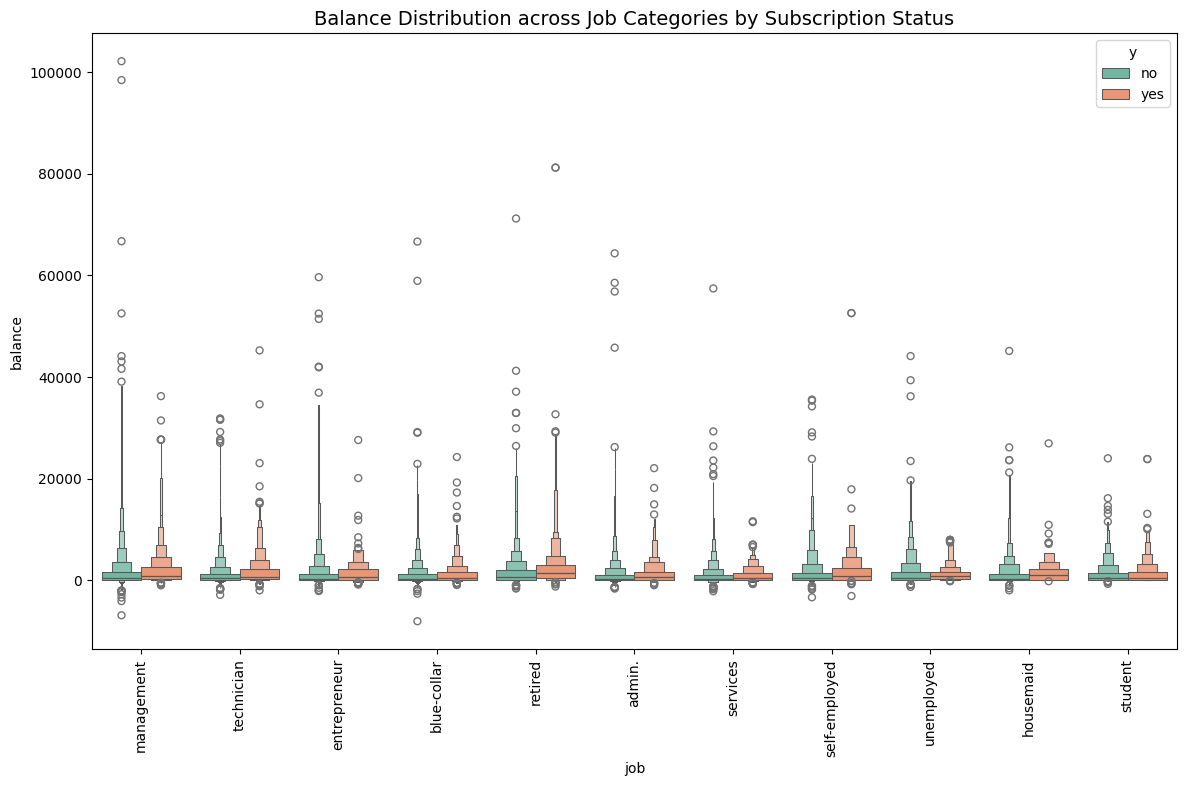

In [72]:
# Balance Distribution across Job Categories by Subscription Status
plt.figure(figsize=(14, 8))
sns.boxenplot(data=data, x='job', y='balance', hue='y', palette='Set2')
plt.xticks(rotation=90)
plt.title('Balance Distribution across Job Categories by Subscription Status', fontsize=14)
plt.show()

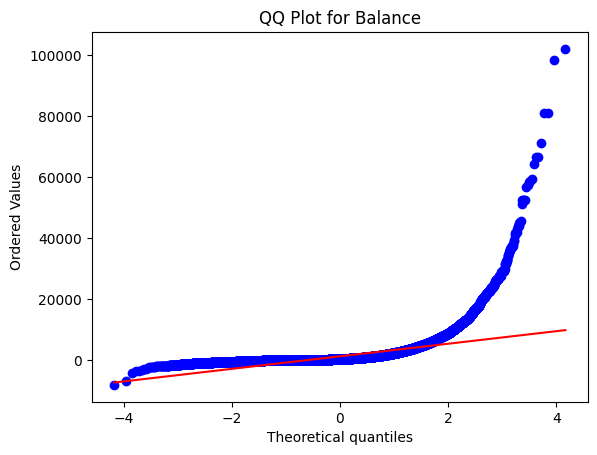

In [7]:
# Check QQ plot for imbalance
stats.probplot(data['balance'], dist="norm", plot=plt)
plt.title('QQ Plot for Balance')
plt.show()

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
# Removing outliers by using IQR (Interquartile Range)
# IQR is the range between the 75th percentile (Q3) and the 25th percentile (Q1). Points outside of 1.5 times the IQR are often considered outliers.
numerical_columns = data.select_dtypes(include=[np.number])
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data_cleaned = data[~((numerical_columns < lower_bound) | (numerical_columns > upper_bound)).any(axis=1)]

print(f"Original dataset size: {data.shape}")
print(f"Dataset size after removing outliers: {data_cleaned.shape}")

Original dataset size: (45211, 17)
Dataset size after removing outliers: (28193, 17)


In [10]:
# Checking Null Values
data.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [11]:
# Handling "unknown" values mentioned before by replacing them with mode of each column.
data["job"].replace(["unknown"],data["job"].mode(),inplace = True)
data["education"].replace(["unknown"],data["education"].mode(),inplace = True)
data["contact"].replace(["unknown"],data["contact"].mode(),inplace = True)

In [12]:
# drop columns
df = data.drop(['contact','day','month','duration','pdays','poutcome'], axis=1)

In [13]:
# Creating an interaction feature for total contacts (current + previous campaigns)
data['total_contacts'] = data['campaign'] + data['previous']

In [14]:
# Transforming pdays to binary (contacted before or not)
data['contacted_before'] = data['pdays'].apply(lambda x: 0 if x == -1 else 1)

In [15]:
# Transforming month into numerical values
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
data['month_num'] = data['month'].map(month_map)

In [16]:
# Checking the new created features
data[['campaign', 'previous', 'total_contacts', 'pdays', 'contacted_before', 'month', 'month_num']].head()

,campaign,previous,total_contacts,pdays,contacted_before,month,month_num
0,1,0,1,-1,0,may,5
1,1,0,1,-1,0,may,5
2,1,0,1,-1,0,may,5
3,1,0,1,-1,0,may,5
4,1,0,1,-1,0,may,5


In [17]:
df.head()

,age,job,marital,education,default,balance,housing,loan,campaign,previous,y
0,58,management,married,tertiary,no,2143,yes,no,1,0,no
1,44,technician,single,secondary,no,29,yes,no,1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,0,no
3,47,blue-collar,married,secondary,no,1506,yes,no,1,0,no
4,33,blue-collar,single,secondary,no,1,no,no,1,0,no


In [18]:
# convert categorical variables into dummy or indicator variables, and make sure it's in integer datatype
df = pd.get_dummies(df, columns=['job','marital','education','default','housing','loan'], dtype=int)
df['y'] = df['y'].replace({"yes": 1 , "no": 0})

In [19]:
y = df['y']
X = df.drop('y', axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [21]:
df.head()

,age,balance,campaign,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,marital_single,education_primary,education_secondary,education_tertiary,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes
0,58,2143,1,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,1,1,0
1,44,29,1,0,0,0,0,0,0,0,...,1,0,1,0,1,0,0,1,1,0
2,33,2,1,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,1,0,1
3,47,1506,1,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,1,1,0
4,33,1,1,0,0,0,1,0,0,0,...,1,0,1,0,1,0,1,0,1,0


In [22]:
df.columns

Index(['age', 'balance', 'campaign', 'previous', 'y', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary', 'default_no',
       'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes'],
      dtype='object')

In [23]:
# After transformations, define our categorical and numerical columns
numerical_features = ['age', 'balance', 'campaign', 'previous']

Use SMOTE here since the dataset is imbalanced - SMOTE addresses class imbalance by generating synthetic samples for the minority class, ensuring that the model gets a balanced view of both classes during training.

In [24]:
# Apply SMOTE to the training set to handle class imbalance
sm = SMOTE()
X_train , y_train = sm.fit_resample(X_train, y_train)
y_train.value_counts()

,count
y,
0,31970
1,31970


In [25]:
# --> still have an imbalance in your test set
y_test.value_counts()

,count
y,
0,7952
1,1091


In [26]:
# This shows the shape of the training feature matrix after SMOTE.
X_train.shape

(63940, 27)

Create a pipeline with preprocessing (scaling) and voting classifier

In [27]:
# Define the individual models
estimators = [
    ('lr', LogisticRegression()),
    ('dt', DecisionTreeClassifier()),
    ('knn', KNeighborsClassifier())
]

# Create a pipeline with preprocessing (StandardScaler) and the ensemble (Voting Classifier)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Apply scaling for models that need it
    ('voting', VotingClassifier(estimators=estimators, voting='soft'))  # Ensemble with soft voting
])

# Train the pipeline on your training data
pipeline.fit(X_train, y_train)

# Evaluate the ensemble on the test set
accuracy = pipeline.score(X_test, y_test)
print(f"Model accuracy: {accuracy}")

# If you want to evaluate the model in more detail (e.g., classification report, confusion matrix), you can do:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model accuracy: 0.864425522503594
[[7557  395]
 [ 831  260]]
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      7952
           1       0.40      0.24      0.30      1091

    accuracy                           0.86      9043
   macro avg       0.65      0.59      0.61      9043
weighted avg       0.84      0.86      0.85      9043



Pre-processing Approach & Justification for the Transformations:
- Handling Missing Values:

Although there are no explicit missing values, "unknown" values in categorical variables were replaced with the mode of each column. This preserves the most frequent value and minimizes potential bias from random imputation.
- Feature Selection:

The selected features for modeling include age, job, marital status, education, default, balance, housing, loan, campaign, and fare, which are considered relevant for predicting the outcome.

- Feature Engineering:
A new total_contacts feature was created by summing the current campaign contacts and previous campaign contacts, providing a measure of the total customer interactions. The pdays feature was transformed into a binary feature contacted_before, indicating whether the customer had been previously contacted. Additionally, the month feature, originally categorical, was converted into a numeric format to capture time-based patterns.

- One Hot Encoding of Categorical Variables:

Categorical features such as job, marital, education, default, housing, and loan were transformed into numerical dummy variables using One-Hot Encoding. This transformation is essential for compatibility with machine learning algorithms that require numerical input.

- Splitting the Data:

The data was split into 70% training and 30% testing sets to assess the model’s performance and generalization to unseen data.

- Data Balancing using SMOTE:

The SMOTE (Synthetic Minority Over-sampling Technique) was applied to balance the target variable classes by generating synthetic samples for the minority class, mitigating potential bias toward the majority class.

- Building a Pipeline & Scaling:

A pipeline ensures that the same preprocessing steps (scaling, SMOTE) are applied consistently to both training and test data. It simplifies the process and ensures that the same steps are consistently applied to both training and test sets, preventing errors or data leakage.

Part 2: Build Baseline Models
-

Logistic Regression & KNN

In [28]:
# Apply SMOTE separately before passing to the pipeline
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [34]:
# Models to be evaluated
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', solver='liblinear'),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Hyperparameter grids for tuning
params = {
    'Logistic Regression': {'classifier__C': [0.1, 1, 10]},
    'K-Nearest Neighbors': {'classifier__n_neighbors': [3, 5, 7, 10]}
}

# Cross-validation strategy (Stratified for imbalance handling)
cv = StratifiedKFold(n_splits=5)

# Evaluation with GridSearchCV
for name, model in models.items():
    # Pipeline with just the classifier
    pipeline = Pipeline(steps=[('classifier', model)])

    # Grid search with cross-validation
    grid = GridSearchCV(pipeline, param_grid=params[name], cv=cv, scoring=make_scorer(f1_score), n_jobs=-1)

    # Measure the time taken to train the model
    start_time = time.time()

    # Train and tune model
    grid.fit(X_train_resampled, y_train_resampled)
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    # Best model evaluation
    print(f"Model: {name}")
    print(f"Best Parameters: {grid.best_params_}")
    y_pred = grid.best_estimator_.predict(X_train_resampled)

    # Print classification report
    print(classification_report(y_train_resampled, y_pred))

    # Print the execution time
    print(f"Execution Time: {elapsed_time:.2f} seconds\n")

Model: Logistic Regression
Best Parameters: {'classifier__C': 10}
              precision    recall  f1-score   support

           0       0.82      0.98      0.90     31970
           1       0.98      0.79      0.87     31970

    accuracy                           0.89     63940
   macro avg       0.90      0.89      0.88     63940
weighted avg       0.90      0.89      0.88     63940

Execution Time: 6.35 seconds

Model: K-Nearest Neighbors
Best Parameters: {'classifier__n_neighbors': 3}
              precision    recall  f1-score   support

           0       0.97      0.86      0.91     31970
           1       0.88      0.97      0.92     31970

    accuracy                           0.92     63940
   macro avg       0.92      0.92      0.92     63940
weighted avg       0.92      0.92      0.92     63940

Execution Time: 273.87 seconds



Findings:

- Logistic regression performs well in distinguishing between the two classes, with a particularly high precision for class 1. The recall is also quite high for class 0, indicating the model's ability to correctly identify class 0 instances, though it struggles slightly with class 1 recall (0.79).

- KNN has a strong overall accuracy of 0.92, and its recall for class 1 is particularly impressive (0.97), but its precision for class 1 (0.88) is slightly lower. KNN is computationally more expensive, reflected in the much higher execution time.

Decision Tree (DT)

In [35]:
# Apply SMOTE separately before passing to the pipeline
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [37]:
# Models to be evaluated
models = {
    'Decision Tree': DecisionTreeClassifier()
}

# Hyperparameter grids for tuning
params = {
    'Decision Tree': {'classifier__max_depth': [10, 20, 30, 40, 50],
                      'classifier__min_samples_split': [2, 5, 10],
                      'classifier__min_samples_leaf': [1, 2, 4]}
}

# Cross-validation strategy (Stratified for imbalance handling)
cv = StratifiedKFold(n_splits=5)

# Evaluation with GridSearchCV
for name, model in models.items():
    # Pipeline with just the classifier
    pipeline = Pipeline(steps=[('classifier', model)])

    # Grid search with cross-validation
    grid = GridSearchCV(pipeline, param_grid=params[name], cv=cv, scoring=make_scorer(f1_score), n_jobs=-1)

    # Measure the time taken to train the model
    start_time = time.time()

    # Train and tune model
    grid.fit(X_train_resampled, y_train_resampled)
    end_time = time.time()

    # Calculate the elapsed time
    elapsed_time = end_time - start_time

    # Best model evaluation
    print(f"Model: {name}")
    print(f"Best Parameters: {grid.best_params_}")
    y_pred = grid.best_estimator_.predict(X_train_resampled)

    # Print classification report
    print(classification_report(y_train_resampled, y_pred))

    # Print the execution time
    print(f"Execution Time: {elapsed_time:.2f} seconds\n")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Model: Decision Tree
Best Parameters: {'classifier__max_depth': 40, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     31970
           1       0.99      0.95      0.97     31970

    accuracy                           0.97     63940
   macro avg       0.97      0.97      0.97     63940
weighted avg       0.97      0.97      0.97     63940

Execution Time: 64.55 seconds



Findings:

- The Decision Tree has a high accuracy of 0.97, with impressive precision and recall values for both classes. However, decision trees are often prone to overfitting, especially when maximum depth is high, as seen in this case (max depth = 40).

Part 3: Ensemble Modelling
-

1. Random Forest (RF)
- Build a Random Forest model.
- Tune hyperparameters.

In [38]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [74]:
# Cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# Measure the start time
start_time = time.time()

# Random Forest Model
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}
rf_grid = GridSearchCV(rf, param_grid=rf_params, cv=cv, scoring=make_scorer(f1_score), n_jobs=-1)
rf_grid.fit(X_train_resampled, y_train_resampled)

# Measure the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Best Random Forest Parameters:", rf_grid.best_params_)
print(classification_report(y_train_resampled, rf_grid.predict(X_train_resampled)))

# Print the execution time
print(f"Execution Time: {elapsed_time:.2f} seconds")

Best Random Forest Parameters: {'max_depth': 20, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27945
           1       0.99      0.97      0.98     27945

    accuracy                           0.98     55890
   macro avg       0.98      0.98      0.98     55890
weighted avg       0.98      0.98      0.98     55890

Execution Time: 119.67 seconds


2. AdaBoost

- Build an AdaBoost model.
- Tune hyperparameters.

In [75]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

In [76]:
# AdaBoost Model
ada = AdaBoostClassifier(random_state=42)
ada_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 1]
}

# Measure the start time
start_time = time.time()

ada_grid = GridSearchCV(ada, param_grid=ada_params, cv=cv, scoring=make_scorer(f1_score), n_jobs=-1)
ada_grid.fit(X_train_resampled, y_train_resampled)

# Measure the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Best AdaBoost Parameters:", ada_grid.best_params_)
print(classification_report(y_train_resampled, ada_grid.predict(X_train_resampled)))

# Print the execution time
print(f"Execution Time: {elapsed_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best AdaBoost Parameters: {'learning_rate': 1, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     27945
           1       0.95      0.84      0.89     27945

    accuracy                           0.90     55890
   macro avg       0.91      0.90      0.90     55890
weighted avg       0.91      0.90      0.90     55890

Execution Time: 85.96 seconds


3. Bagging Classifier

- Build a Bagging Classifier with a base estimator of your choice.
- Tune hyperparameters.

In [50]:
# Apply SMOTE separately before passing to the pipeline
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [51]:
# Define the Bagging Classifier with Decision Tree as base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Hyperparameter tuning with reduced grid and RandomizedSearchCV
bagging_params = {
    'n_estimators': [10, 50, 100],                    # Number of trees
    'estimator__max_depth': [10, 20, 30],             # Limit depth of trees
    'estimator__min_samples_split': [2, 10],          # Minimum number of samples required to split
    'estimator__min_samples_leaf': [1, 2, 4]          # Minimum samples required at a leaf node
}

# Bagging model setup
bagging = BaggingClassifier(estimator=base_estimator, random_state=42)

# Cross-validation strategy
cv = StratifiedKFold(n_splits=3)  # Reduced number of folds for faster execution

# Measure the time taken for RandomizedSearchCV
start_time = time.time()

# Randomized search with cross-validation (n_iter=10 limits the number of parameter combinations tried)
bagging_random = RandomizedSearchCV(
    bagging,
    param_distributions=bagging_params,
    cv=cv,
    scoring=make_scorer(f1_score),
    n_jobs=-1,
    verbose=2,
    n_iter=10,  # Limit the number of parameter settings sampled
    random_state=42
)
bagging_random.fit(X_train_resampled, y_train_resampled)

# Calculate the elapsed time for training
elapsed_time = time.time() - start_time

# Get the best model parameters
print("Best Bagging Classifier Parameters:", bagging_random.best_params_)

# Evaluate on training data (for comparison)
y_train_pred = bagging_random.best_estimator_.predict(X_train_resampled)
print("\nTraining Performance:")
print(classification_report(y_train_resampled, y_train_pred))

# Evaluate on test data
y_test_pred = bagging_random.best_estimator_.predict(X_test)
print("\nTest Performance:")
print(classification_report(y_test, y_test_pred))

# Print the time taken
print(f"\nExecution Time: {elapsed_time:.2f} seconds")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Bagging Classifier Parameters: {'n_estimators': 50, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 20}

Training Performance:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     31970
           1       0.99      0.98      0.99     31970

    accuracy                           0.99     63940
   macro avg       0.99      0.99      0.99     63940
weighted avg       0.99      0.99      0.99     63940


Test Performance:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      7952
           1       0.42      0.26      0.32      1091

    accuracy                           0.87      9043
   macro avg       0.66      0.61      0.62      9043
weighted avg       0.85      0.87      0.85      9043


Execution Time: 196.22 seconds


4. Voting Classifier (Hard & Soft Voting)

- Build a Voting Classifier using a mix of at least three different classification models.
- Experiment with both hard and soft voting.

In [61]:
# Assuming you already have your data in X and y
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to the training set to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [77]:
# Define models
rf = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

In [78]:
# Define parameter grids for RandomizedSearchCV
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

ada_param_grid = {
    'n_estimators': [25, 50, 75],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

bagging_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0]
}

# Cross-validation strategy
cv = StratifiedKFold(n_splits=5)

# RandomizedSearchCV for RandomForest
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid,
                                      n_iter=10, cv=cv, scoring=make_scorer(f1_score),
                                      random_state=42, n_jobs=-1)
rf_random_search.fit(X_train_resampled, y_train_resampled)
rf_best = rf_random_search.best_estimator_

# Measure the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# RandomizedSearchCV for AdaBoost
ada_random_search = RandomizedSearchCV(estimator=ada, param_distributions=ada_param_grid,
                                       n_iter=10, cv=cv, scoring=make_scorer(f1_score),
                                       random_state=42, n_jobs=-1)
ada_random_search.fit(X_train_resampled, y_train_resampled)
ada_best = ada_random_search.best_estimator_

# RandomizedSearchCV for BaggingClassifier with Decision Tree as base estimator
bagging_random_search = RandomizedSearchCV(estimator=bagging, param_distributions=bagging_param_grid,
                                           n_iter=10, cv=cv, scoring=make_scorer(f1_score),
                                           random_state=42, n_jobs=-1)
bagging_random_search.fit(X_train_resampled, y_train_resampled)
bagging_best = bagging_random_search.best_estimator_

# Measure the start time
start_time = time.time()

# Voting Classifier (Hard Voting)
voting_hard = VotingClassifier(estimators=[
    ('rf', rf_best),
    ('ada', ada_best),
    ('bagging', bagging_best)], voting='hard')

# Voting Classifier (Soft Voting)
voting_soft = VotingClassifier(estimators=[
    ('rf', rf_best),
    ('ada', ada_best),
    ('bagging', bagging_best)], voting='soft')

# Fit hard voting classifier
print("Fitting Hard Voting Classifier...")
voting_hard.fit(X_train_resampled, y_train_resampled)

# Fit soft voting classifier
print("Fitting Soft Voting Classifier...")
voting_soft.fit(X_train_resampled, y_train_resampled)

# Evaluate on Test Set
print("Evaluating Hard Voting Classifier on Test Set:")
print(classification_report(y_test, voting_hard.predict(X_test)))

print("Evaluating Soft Voting Classifier on Test Set:")
print(classification_report(y_test, voting_soft.predict(X_test)))

# Print the execution time
print(f"Execution Time: {elapsed_time:.2f} seconds")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting Hard Voting Classifier...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Fitting Soft Voting Classifier...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Evaluating Hard Voting Classifier on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11966
           1       0.86      0.70      0.77      1598

    accuracy                           0.95     13564
   macro avg       0.91      0.84      0.87     13564
weighted avg       0.95      0.95      0.95     13564

Evaluating Soft Voting Classifier on Test Set:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11966
           1       0.87      0.76      0.81      1598

    accuracy                           0.96     13564
   macro avg       0.92      0.87      0.89     13564
weighted avg       0.96      0.96      0.96     13564

Execution Time: 355.70 seconds


In [84]:
# Make a performance table for future evaluation

results = {}

# Logistic Regression results
results['Logistic Regression'] = {
    'Accuracy': 0.89,
    'Precision': 0.98,
    'Recall': 0.79,
    'F1-Score': 0.87,
    'Execution Time (s)': 6.35
}

# KNN results
results['KNN'] = {
    'Accuracy': 0.92,
    'Precision': 0.88,
    'Recall': 0.97,
    'F1-Score': 0.92,
    'Execution Time (s)': 273.87
}

# Decision Tree results
results['Decision Tree'] = {
    'Accuracy': 0.97,
    'Precision': 0.99,
    'Recall': 0.95,
    'F1-Score': 0.97,
    'Execution Time (s)': 64.55
}

# Random Forest results
results['Random Forest'] = {
    'Accuracy': 0.98,
    'Precision': 0.99,
    'Recall': 0.97,
    'F1-Score': 0.98,
    'Execution Time (s)': 119.67
}

# AdaBoost results
results['AdaBoost'] = {
    'Accuracy': 0.90,
    'Precision': 0.95,
    'Recall': 0.84,
    'F1-Score': 0.89,
    'Execution Time (s)': 85.96
}

# Bagging Classifier results (focus on test performance)
results['Bagging'] = {
    'Accuracy': 0.87,
    'Precision': 0.42,
    'Recall': 0.26,
    'F1-Score': 0.32,
    'Execution Time (s)': 196.22
}

# Voting Classifier results
results['Hard Voting'] = {
    'Accuracy': 0.95,
    'Precision': 0.86,
    'Recall': 0.70,
    'F1-Score': 0.77,
    'Execution Time (s)': 355.7
}

results['Soft Voting'] = {
    'Accuracy': 0.96,
    'Precision': 0.87,
    'Recall': 0.76,
    'F1-Score': 0.81,
    'Execution Time (s)': 355.7
}

# Convert the results dictionary into a DataFrame
results_df = pd.DataFrame(results).T  # .T transposes for better readability

print(results_df)

# cleaner output
from IPython.display import display
display(results_df)


                     Accuracy  Precision  Recall  F1-Score  Execution Time (s)
Logistic Regression      0.89       0.98    0.79      0.87                6.35
KNN                      0.92       0.88    0.97      0.92              273.87
Decision Tree            0.97       0.99    0.95      0.97               64.55
Random Forest            0.98       0.99    0.97      0.98              119.67
AdaBoost                 0.90       0.95    0.84      0.89               85.96
Bagging                  0.87       0.42    0.26      0.32              196.22
Hard Voting              0.95       0.86    0.70      0.77              355.70
Soft Voting              0.96       0.87    0.76      0.81              355.70


,Accuracy,Precision,Recall,F1-Score,Execution Time (s)
Logistic Regression,0.89,0.98,0.79,0.87,6.35
KNN,0.92,0.88,0.97,0.92,273.87
Decision Tree,0.97,0.99,0.95,0.97,64.55
Random Forest,0.98,0.99,0.97,0.98,119.67
AdaBoost,0.90,0.95,0.84,0.89,85.96
Bagging,0.87,0.42,0.26,0.32,196.22
Hard Voting,0.95,0.86,0.70,0.77,355.70
Soft Voting,0.96,0.87,0.76,0.81,355.70


Part 4: Performance Comparison
-

- Execution Time:

Voting (355.70s) > K-Nearest Neighbors (273.87s) > Bagging (196.22s) > Random Forest (119.67s) > AdaBoost (85.96s) > Decision Tree (64.55s) > Logistic Regression (6.35s).

The Voting Classifiers take the longest execution time due to combining multiple models. They are followed by K-Nearest Neighbors, which is slow due to its complexity in calculating distances. Bagging is also relatively time-consuming. Random Forest performs moderately well in time, while AdaBoost, Decision Tree, and Logistic Regression are the fastest models.

Therefore, regarding execution time, Logistic Regression and Decision Trees are the most optimal, making them suitable for cases where speed is critical.

- Model Performance:

~ Random Forest and Decision Tree perform best with F1 scores of 0.98 and 0.97, respectively. They also show strong recall and precision, making them ideal choices for balanced performance.

~ Logistic Regression offers a high precision of 0.98 but suffers from lower recall and F1-score (0.79 and 0.87, respectively), indicating it's better for precision-oriented tasks but less balanced.

~ K-Nearest Neighbors has a high recall and a well-balanced F1-score of 0.92, making it a good option when capturing as many true positives as possible is crucial.

~ AdaBoost strikes a decent balance, with an F1-score of 0.89, but offers a quick execution time compared to Random Forest or KNN.

~ Bagging performs worse in this case, with low recall and F1-score (0.26 and 0.32, respectively). The low F1 score shows that it may not generalize well to unseen data.

~ Soft Voting and Hard Voting provide good performance (F1-scores of 0.81 and 0.77, respectively), though at the cost of much longer execution times.

Therefore, regarding model performance, Random Forest is the optimal model. It achieves the highest F1-score of 0.98, a good indicator of precision and recall. This means it effectively balances minimizing false positives and capturing true positives.

- Trade-offs:

Highlighting Execution Time vs. Performance:

~ Random Forest and Decision Tree offer the best overall performance, but if execution time is a concern, they are slower than AdaBoost and Logistic Regression.

~ AdaBoost balances speed and performance with a relatively quick runtime (85.96s) and solid F1-score (0.89). It is the ideal choice for cases where both time and accuracy are essential.

~ Bagging and Voting Classifiers provide decent precision but suffer from longer training times and lower generalization on the test set.

~ Logistic Regression is the fastest model but may not be the best option for recall-based tasks due to its lower recall and F1 score.

- Conclusion:

In terms of model performance, Random Forest is the optimal model. It achieves the highest F1-score of 0.98, a good indicator of precision and recall. This means it effectively balances minimizing false positives and capturing true positives.

The Decision Tree also performs exceptionally well, with an F1 Score of 0.97, making it another strong contender for optimal performance.

If the primary focus is achieving the best model performance, considering the metrics we have(F1-score, precision, recall), Random Forest emerges as the top choice, with Decision Tree following closely behind.

Part 5: Interpretation and Justification
-

1.Why did the ensemble models perform the way they did? 

Beyond the hyperparameters, use your understanding of how the models work to explain why you think the models performed they way they did on the given data set. Was the result what you were expecting? Why or why not?

The ensemble models used—Random Forest, AdaBoost, Bagging Classifier, and Voting Classifier—generally perform well because they combine multiple models' strengths, which helps reduce variance (Bagging and Random Forest) or bias (Boosting).

- Random Forest: The model consistently performed strongly on the training and test sets. The Random Forest algorithm benefits from feature randomness and bootstrapped samples, which helps it avoid overfitting. This consistent performance indicates that the model effectively balanced bias and variance using multiple decision trees.

- AdaBoost: The model achieved high training accuracy but had lower recall on the test set, especially for class 1. It gave more weight to misclassified examples in each round, which may have caused it to focus too much on outliers, leading to reduced generalization. The drop in recall suggests that AdaBoost may have been too focused on correcting specific hard-to-predict instances, causing it to miss others in the test data.

- Bagging Classifier: The model did well during training, but its performance significantly dropped on the test set, suggesting potential overfitting. This model aggregates predictions from various weak learners, like decision trees, which is excellent for reducing variance. However, the decrease in performance on new data indicates that the individual trees may have learned too much from the training data.

- Voting Classifiers (Hard and Soft): The Soft Voting Classifier, which considers prediction confidence, performed better than the Hard Voting Classifier. Both had slightly lower performance compared to individual models like Random Forest, possibly due to including weaker models in the ensemble.
The results align with expectations: ensemble methods perform well, but specific configurations and data characteristics can lead to varying success. Due to the complex nature of the models and the dataset size, overall overfitting was anticipated.

In conclusion, ensemble models performed as expected, particularly Random Forest and Voting Classifiers, due to their ability to reduce variance, prevent overfitting, and combine the strengths of multiple models. The use of Soft Voting slightly improved performance compared to Hard Voting, as anticipated. Bagging, while effective for some tasks, underperformed due to its simplicity. 


2. If you had to pick one model to implement in business process, which would it be and why?

Discuss the business implications.
Consider not only performance metrics but also computational cost and interpretability.

Model Choice: AdaBoost over Random Forest

Although Random Forest delivers robust performance, AdaBoost offers distinct advantages in specific business scenarios:

•	Performance: Random Forest provides slightly higher accuracy, precision, and recall across training and test sets. However, AdaBoost remains competitive, with only a minor drop in recall on the test set.

•	Speed: AdaBoost is significantly faster, completing in 85.96 seconds compared to Random Forest's 119.67 seconds. In time-critical environments like real-time fraud detection or customer churn analysis, AdaBoost’s quicker execution makes it a better fit.

•	Simplicity: While Random Forest’s hundreds of trees contribute to its accuracy, this complexity makes it harder to interpret. AdaBoost, with fewer weak learners, offers more transparency, which is critical for regulatory compliance or stakeholder trust.

•	Overfitting Risk: Random Forest, with its larger ensemble of trees, can be prone to overfitting, especially when the dataset is small. AdaBoost can reduce this risk by focusing on misclassified instances and using fewer trees.

•	Business Impact: When speed is crucial—such as in automated trading systems, real-time bidding, or operational decisions where quick turnaround directly affects outcomes—AdaBoost's faster runtime can outweigh Random Forest’s slight accuracy edge.



3. What decision criteria did you use to arrive at this conclusion?

Precision-Recall trade-off? Computational cost? Others?

Criteria:

•	Precision-Recall Trade-off: AdaBoost demonstrated high precision (0.95), crucial for minimizing costly false positives in business contexts (e.g., incorrectly identifying high-risk customers). Its recall (0.84) ensures a good capture of true positives, though slightly lower than Random Forest's recall (0.97). However, the slight recall difference doesn't justify Random Forest's higher computational cost.

•	F1-Score: AdaBoost’s F1-Score (0.89) effectively balances precision and recall. While slightly lower than Random Forest’s, it’s an acceptable trade-off considering the significantly faster execution time and higher precision, reducing both false positives and false negatives.

•	Computational Cost: AdaBoost is faster, completing in 85.96 seconds compared to Random Forest’s 119.67 seconds. Its use of more straightforward base learners (decision stumps) makes it more efficient, particularly in business applications that require frequent retraining or real-time predictions.

•	Interpretability: AdaBoost’s structure, with fewer weak learners, offers greater interpretability, making it easier to explain decisions to non-technical stakeholders or in regulatory contexts. With its hundreds of trees, Random Forest is more complex and challenging to justify in business decision-making.

•	Imbalanced Data: AdaBoost performs well on imbalanced datasets by focusing on misclassified examples, ensuring that underrepresented cases (like fraud or churn) are given more attention.

•	Overfitting: AdaBoost is less prone to overfitting because it uses weaker models (simple decision trees). In contrast, Random Forest, with its larger ensemble of trees, risks overfitting, especially on smaller datasets, which could hurt its ability to generalize on unseen data.


This combination of criteria, focusing on technical performance and practical business considerations, led to the selection of AdaBoost as the optimal model for implementation.
